In [1]:
import sys
sys.path.append("../")

from functools import partial
from pprint import pprint
from termcolor import colored

import torch

from tqdm import tqdm

from search_strategies import create_search_strategy
from pcfg import PCFG
from grammars import grammars
from evaluation import evaluation_fn
from arguments import parse_arguments
from data import get_data_loaders
from utils import load_config, Limiter

import numpy as np
from matplotlib import pyplot as plt

import copy
import time

from search_state import DerivationTreeNode, Operation
from grammars import einspace


In [2]:
class ARGS():
    def __init__(self, config, device):
        self.config = config
        self.device = device
        self.acquisition_fn = "uct"
        self.exploration_weight = 1.0
        self.incubent_type = "parent"
        self.reward_mode = "sum"
        self.regularised = True
        self.vis_interval = 10
        self.add_full_paths = False
        
args = ARGS("../configs/einspace/evolution_test/addnist/evolution_einspace_quick.yaml", "cpu")
args = load_config(args)
args.time_limit = 10
#pprint(vars(args))

# set the seed
torch.manual_seed(args.seed)

# create the limiter
# this makes sure that the search does not exceed
# time, memory (GPU and RAM), depth, or node limits during the search
limiter = Limiter(
    limits={
        "time": args.time_limit,
        "max_id": args.max_id_limit,
        "depth": args.depth_limit,
        "memory": args.mem_limit,
        "individual_memory": args.individual_mem_limit,
        "batch_pass": args.batch_pass_limit,
    }
)

# create the grammar
grammar = PCFG(
    grammar=grammars[args.search_space],
    limiter=limiter,
)
#print(grammar)

train_loader, val_loader, _, _ = get_data_loaders(
    dataset=args.dataset,
    batch_size=args.batch_size,
    image_size=args.image_size,
    root="../../einspace/data",
    load_in_gpu=args.load_in_gpu,
    device=args.device,
    log=args.verbose_eval,
)

eval_fn = partial(
    evaluation_fn,
    args=args,
    train_loader=train_loader,
    val_loader=val_loader,
)

# create the input parameters
input_params = {
    "shape": torch.Size([1, args.channels, *args.image_size]),
    "other_shape": None,
    "mode": "im",
    "other_mode": None,
    "branching_factor": 1,
    "last_im_shape": None,
}

# create the search strategy
search = create_search_strategy(args, grammar, eval_fn, limiter, input_params)

Limiter({'time': 10, 'max_id': 10000, 'depth': 20, 'memory': 8192, 'individual_memory': 1024, 'batch_pass': 0.1})
Loaded addnist in GPU. Size: 658MB
Architecture seed: None
No previous search results found, starting from scratch
Initialised MCTS at 103636.664272137


In [7]:
class matrix_cell():
    def __init__(self):
        self.top = np.nan
        self.left = np.nan
        self.corner = np.nan
        self.operation = ""
        self.value = np.nan

    def __str__(self):
        return str(self.value)+" ("+self.operation+")"

    def __repr__(self):
        return str(self.value)+" ("+self.operation+")"


class decoy(object):
    # This is an empty object to hold an operation name and id as if it was a node
    def __init__(self, operation = True):
        if operation:
            self.operation = decoy(False)
            self.operation.name = ""
            self.id = np.nan


class align_matrix():
    def __init__(self, model1, model2, verbose = False):
        self.verbose = verbose
        
        self.model1 = model1
        if self.verbose: print("First model: ", self.model1)
        self.model_ops1, self.matches1, _, _ = self.breakdown(self.model1, pstack = [], n = -1, matches = [])
        self.model_ops1 = [decoy()] + self.model_ops1
        
        self.model2 = model2
        if self.verbose: print("Second model:", self.model2)
        self.model_ops2, self.matches2, _, _ = self.breakdown(self.model2, pstack = [], n = -1, matches = [])
        self.model_ops2 = [decoy()] + self.model_ops2
        
        self.order_matches()
        self.size = (len(self.model_ops1), len(self.model_ops2))
        self.operations = []
        
        timestart = time.time()
        self.matrix = self.calculate_matrix(self.model_ops1, self.model_ops2, corner_value = 0, corner_op = "start", block_idx=(0,0))
        self.trace_back()
        if self.verbose:
            print("\nDistance of", round(self.distance,2), "through", self.nontrivial_ops, "operations, calculated in" ,round((time.time()-timestart)*1000,2),"ms.")
            self.print_alignment_matrix()

    def order_matches(self):
        self.matches1.sort()
        self.g1 = self.get_group_idx(self.model_ops1, self.matches1)
        for m, match in enumerate(self.matches1):
            self.matches1[m] = [idx+1 for idx in match]
        self.matches1 = [[0, len(self.model_ops1)-1]] + self.matches1
        
        self.matches2.sort()
        self.g2 = self.get_group_idx(self.model_ops2, self.matches2)
        for m, match in enumerate(self.matches2):
            self.matches2[m] = [idx+1 for idx in match]
        self.matches2 = [[0, len(self.model_ops2)-1]] + self.matches2
    
    def breakdown(self, model, pstack = [], n = 0, matches = []):
        model_ops = []
        
        condition = model.operation
        if model.parent: condition = condition and ("computation" not in model.parent.operation.name) 
            
        if condition:
            if not ("sequential" in model.operation.name):
                n += 1
                # Initialize the operation and id and start submodule if it is a branching or routing module
                model_ops = [model]
                
                if "branching" in model.operation.name or "routing" in model.operation.name:
                    pstack.append(n)
    
            # Append the operation and id of each child
            if model.operation.name == "branching(2)":
                model_ops = [model, model.children[0]]
                n += 1
                model_sub_op, matches, pstack, n = self.breakdown(model.children[1], pstack, n, matches)
                model_ops += model_sub_op
                n += 1
                model_sub_op, matches, pstack, n = self.breakdown(model.children[2], pstack, n, matches)
                model_ops += [decoy()]+model_sub_op+[model.children[-1]]
                n += 1
                
            else:
                for child in model.children:
                    model_sub_op, matches, pstack, n = self.breakdown(child, pstack, n, matches)
                    model_ops += model_sub_op
            
            if "branching" in model.operation.name or "routing" in model.operation.name:
                matches += [(pstack.pop(), n)]
    
        return model_ops, matches, pstack, n
        
    
    def get_group_idx(self, model_ops, matches):
        group_idx = [0]*len(model_ops)
        for idx, match in enumerate(matches):
            for idx2 in range(match[0]+1,match[1]+2):
                group_idx[idx2] = idx+1
        return group_idx
                
    def print_alignment_matrix(self, matrix=None, model_ops1=None, model_ops2=None):
        if matrix == None:
            matrix = self.matrix
            model_ops1 = self.model_ops1
            model_ops2 = self.model_ops2
            
        size = (len(matrix), len(matrix[0]))
        m = np.zeros(size)
        for i in range(size[0]):
            for j in range(size[1]):
                if matrix[i][j].operation == "add":
                    plt.plot((j, j), (i-1, i), "dimgrey")
                elif matrix[i][j].operation == "block_add":
                    plt.plot((j, j), (i-1, i), color = "dimgrey", linestyle = "dashed")
                elif matrix[i][j].operation == "rem":
                    plt.plot((j-1, j), (i, i), "dimgrey")
                elif matrix[i][j].operation == "block_rem":
                    plt.plot((j-1, j), (i, i), color = "dimgrey", linestyle = "dashed")
                elif matrix[i][j].operation == "mut":
                    plt.plot((j-1, j), (i-1, i), "dimgrey")
                elif matrix[i][j].operation == "block_mut":
                    plt.plot((j, j), (i, i), color = "dimgrey", marker = "x")
                m[i,j] = matrix[i][j].value

        max_weight = 0
        for op in self.operations:
            max_weight = max(max_weight, op[4])
        max_weight += 0.00000001
        
        plt.imshow(m)
        ax = plt.gca()
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        ax.set_yticks([x for x in range(len(model_ops1))])
        ax.set_yticklabels([self.get_op_name(op) for op in model_ops1], rotation=0)
        ax.set_xticks([y for y in range(len(model_ops2))])
        ax.set_xticklabels([self.get_op_name(op) for op in model_ops2], rotation=90)
        
        for op in self.operations:
            weight_color = (0,op[4]/max_weight,1-op[4]/max_weight)
            plt.plot((op[2][1], op[3][1]), (op[2][0], op[3][0]), color = weight_color, linewidth=2)
            plt.scatter((op[2][1], op[3][1]), (op[2][0], op[3][0]), color = weight_color, linewidth=2)
        plt.show()

    def get_op_name(self, op):
        if ("routing" in op.operation.name or "branching" in op.operation.name) and op.operation.name != "branching(2)": return op.operation.name.split("(")[0]
        elif "computation" in op.operation.name: return "comp<"+op.children[0].operation.name+">"
        else: return op.operation.name
        
    def trace_back(self, from_pos = "end"):
        if from_pos == "end": from_pos = (self.size[0]-1, self.size[1]-1)
        if self.verbose: print("\nOperations to change from model 1 to model 2:")
        self.operations = []
        self.distance = self.matrix[-1][-1].value
        self.nontrivial_ops = 0
        i=from_pos[0]
        j=from_pos[1]
        while not self.matrix[i][j].operation == "start":
            ii = i
            jj = j
            if self.matrix[ii][jj].operation == "add":
                i -= 1
                while self.matrix[i][j].operation == "block_add":
                    i -= 1
                #if sum([match[1] == j for match in self.matches2]): self.operations += [["add", (self.model_ops1[i+1].id, self.model_ops2[self.matches2[self.g2[j]][0]].id), (i,j), (ii,jj)]] # If we try to add something after the closing layer of a block, we will concatenate the whole block to the new layer
                if self.matches2[self.g2[j]][1] == j and self.matches2[self.g2[j]][0]>0: self.operations += [["add", (self.model_ops1[i+1].id, self.model_ops2[self.matches2[self.g2[j]][0]].id), (i,j), (ii,jj)]] # If we try to add something after the closing layer of a block, we will concatenate the whole block to the new layer
                else: self.operations += [["add"+" reverse"*(self.matches2[self.g2[j]][0]==j), (self.model_ops1[i+1].id, self.model_ops2[j+(self.matches2[self.g2[j]][0]==j)].id), (i,j), (ii,jj)]] # Else, if we try to add something after the beginning of a block (B or R layer), we will concatenate it to the next layer. Otherwise, we will concatenate it to the previous layer. If we concatenated it to the next layer, we specify it 
                if self.verbose: print(f"\t(+{self.matrix[ii][jj].value-self.matrix[i][j].value}) Add {self.get_op_name(self.model_ops1[i+1])} (id: {self.model_ops1[i+1].id}) from indexes {(i,j)} to {(ii,jj)}")

            elif self.matrix[ii][jj].operation == "rem":
                j -=1
                while self.matrix[i][j].operation == "block_rem":
                    j -= 1
                self.operations += [["rem", self.model_ops2[j+1].id, (i,j), (ii,jj)]]
                if self.verbose: print(f"\t(+{self.matrix[ii][jj].value-self.matrix[i][j].value}) Remove {self.get_op_name(self.model_ops2[j+1])} (id: {self.model_ops2[j+1].id}) from indexes {(i,j)} to {(ii,jj)}")

            elif self.matrix[ii][jj].operation == "mut":
                i -= 1
                j -= 1
                while ("block" in self.matrix[i][j].operation) and (self.matrix[i][j].operation == self.matrix[ii-1][jj-1].operation):
                    if (i==0) or (self.matrix[ii-1][jj-1].operation=="block_rem"): break
                    i -= 1
                while ("block" in self.matrix[i][j].operation) and (self.matrix[i+1][j].operation == self.matrix[ii-1][jj-1].operation):
                    if (j==0) or (self.matrix[ii-1][jj-1].operation=="block_add"): break
                    j -= 1
                self.operations += [["mut", (self.model_ops1[i+1].id,self.model_ops2[j+1].id), (i,j), (ii,jj)]]
                if self.verbose: print(f"\t(+{self.matrix[ii][jj].value-self.matrix[i][j].value}) Substitute {self.get_op_name(self.model_ops2[j+1])} (id: {self.model_ops2[j+1].id}) by {self.get_op_name(self.model_ops1[i+1])} (id: {self.model_ops1[i+1].id}) from indexes {(i,j)} to {(ii,jj)}")

            self.operations[-1] += [self.matrix[ii][jj].value-self.matrix[i][j].value]
            if self.operations[-1][-1]: self.nontrivial_ops += 1
    
    def calculate_matrix(self, model_ops1, model_ops2, corner_value = 0, corner_op = "start", block_idx=(0,0)):
        matrix = []
        size = (len(model_ops1), len(model_ops2))
        for i in range(size[0]): # We initialize the whole matrix with empty cells
            row = []
            for j in range(size[1]):
                row.append(matrix_cell())
            matrix.append(row)
    
        for i in range(size[0]):
            for j in range(size[1]):
                if i==0 and j==0:
                    matrix[0][0].operation = corner_op
                    matrix[0][0].value = corner_value
                else:
                    # If we have not yet filled that position in the matrix we do so
                    if not matrix[i][j].operation or matrix[i][j].operation=="block_mut":
                        b1 = "branching" == self.get_op_name(model_ops1[i]) and i>0
                        b2 = "branching" == self.get_op_name(model_ops2[j]) and j>0
                        b21 = "branching(2)" == self.get_op_name(model_ops1[i]) and i>0
                        b22 = "branching(2)" == self.get_op_name(model_ops2[j]) and j>0
                        r1 = "routing" == self.get_op_name(model_ops1[i]) and i>0
                        r2 = "routing" == self.get_op_name(model_ops2[j]) and j>0
                        # If we are not dealing with any branching or routing we simply calculate the corresponding paths
                        if not r1 and not r2 and not b1 and not b2 and not b21 and not b22:
                            if i > 0 and np.isnan(matrix[i][j].top) and ((self.matches1[self.g1[i+block_idx[0]]][1]+1-block_idx[0] != i) or len(matrix[0])==1):
                                if (j!=0 and i!=size[0]-1) or corner_op in ["start", "second_branch"] or size[1]==1: matrix[i][j].top = matrix[i-1][j].value + 1
                            if j > 0 and np.isnan(matrix[i][j].left) and ((self.matches2[self.g2[j+block_idx[1]]][1]+1-block_idx[1] != j) or len(matrix)==1):
                                if (i!=0 and j!=size[1]-1) or corner_op in ["start", "second_branch"] or size[0]==1: matrix[i][j].left = matrix[i][j-1].value + 1
                            if i > 0 and j > 0 and np.isnan(matrix[i][j].corner):
                                if not((not(j==size[1]-1) and (i==size[0]-1)) or ((j==size[1]-1) and not(i==size[0]-1))) or corner_op in ["start", "second_branch"]:
                                    matrix[i][j].corner = matrix[i-1][j-1].value + self.cost_mut(model_ops1[i], model_ops2[j])

                        elif ((b1 and (r2 or b22)) or (r1 and (b2 or b22)) or (b21 and (b2 or r2))) and (not matrix[i-1][j-1].value==np.nan) and (not (matrix[i-1][j-1].operation in ["block_add", "block_mut", "block_rem", "invalid"])): # If we need to substitute an entire block by another
                            block1 = [idx+extra-block_idx[0] for extra,idx in enumerate(self.matches1[self.g1[i+block_idx[0]]])]
                            block2 = [idx+extra-block_idx[1] for extra,idx in enumerate(self.matches2[self.g2[j+block_idx[1]]])]
                            for idx1 in range(block1[0],block1[1]):
                                for idx2 in range(block2[0],block2[1]):
                                    if idx1!=block1[1]-1 and idx2!=block2[1]-1: matrix[idx1][idx2].operation = "block_mut"
                            matrix[idx1][idx2].corner = matrix[i-1][j-1].value+sum([self.get_op_name(module) not in ["branching", "routing", "branching(2)", ""] for module in model_ops1[block1[0]:block1[1]]])+sum([self.get_op_name(module) not in ["branching", "routing", "branching(2)", ""] for module in model_ops2[block2[0]:block2[1]]])-1
                        else:
                            block1 = [idx+extra-block_idx[0] for extra,idx in enumerate(self.matches1[self.g1[i+block_idx[0]]])]
                            block2 = [idx+extra-block_idx[1] for extra,idx in enumerate(self.matches2[self.g2[j+block_idx[1]]])]
                            submatrix = []
                            if ((r1 and not r2) or (b1 and not b2) or (b21 and not b22)) and not (matrix[i-1][j].operation in ["block_add", "block_mut", "block_rem", "invalid"]):
                                block2 = (j, j+1)
                                for idx1 in range(block1[0],block1[1]-1):
                                    matrix[idx1][j].operation = "block_add"
                                matrix[idx1+1][j].top = matrix[i-1][j].value+sum([self.get_op_name(module) not in ["branching", "routing", "branching(2)", ""] for module in model_ops1[block1[0]:block1[1]]])
                                
                                try:
                                    if not(sum([j+1+block_idx[1] in match for match in self.matches2[1:]]) or self.get_op_name(model_ops2[j+1])==""): matrix[block1[1]-1][j+1].corner = matrix[block1[1]-1][j].top
                                except: pass
                                    
                            elif (((not r1) and r2) or ((not b1) and b2) or ((not b21) and b22)) and not (matrix[i][j-1].operation in ["block_add", "block_mut", "block_rem", "invalid"]):
                                block1 = (i, i+1)
                                for idx2 in range(block2[0],block2[1]-1):
                                    matrix[i][idx2].operation = "block_rem"
                                matrix[i][idx2+1].left = matrix[i][j-1].value+sum([self.get_op_name(module) not in ["branching", "routing", "branching(2)", ""] for module in model_ops2[block2[0]:block2[1]]])
                                
                                try:
                                    if not(sum([i+1+block_idx[0] in match for match in self.matches1[1:]]) or self.get_op_name(model_ops1[i+1])==""): matrix[i+1][block2[1]-1].corner = matrix[i][block2[1]-1].left
                                except: pass
                            
                            elif ((r1 and r2) or (b1 and b2)) and not (matrix[i-1][j-1].operation in ["block_add", "block_mut", "block_rem", "invalid"]):
                                submatrix = self.calculate_matrix(model_ops1[block1[0]:block1[1]], model_ops2[block2[0]:block2[1]], matrix[i-1][j-1].value, "mut", (i+block_idx[0],j+block_idx[1]))
                                submatrix = submatrix[:-1]
                                for idx in range(len(submatrix)):
                                    submatrix[idx] = submatrix[idx][:-1]
                            
                            elif (b21 and b22) and not (matrix[i-1][j-1].operation in ["block_add", "block_mut", "block_rem", "invalid"]):
                                block1 = [idx+extra-block_idx[0] for extra,idx in enumerate(self.matches1[self.g1[i+block_idx[0]]])]
                                block2 = [idx+extra-block_idx[1] for extra,idx in enumerate(self.matches2[self.g2[j+block_idx[1]]])]
                                separator = [1+np.argwhere([(self.get_op_name(op)=="") and (self.g1[idx+1+block_idx[0]]==self.g1[i+block_idx[0]]) for idx, op in enumerate(model_ops1[1:])])[0][0],
                                             1+np.argwhere([(self.get_op_name(op)=="") and (self.g2[idx+1+block_idx[1]]==self.g2[j+block_idx[1]]) for idx, op in enumerate(model_ops2[1:])])[0][0]]

                                submatrix = []
                                m_size = (block1[1]-block1[0], block2[1]-block2[0])
                                for _ in range(m_size[0]): # We initialize the whole matrix with empty cells
                                    row = []
                                    for _ in range(m_size[1]):
                                        row.append(matrix_cell())
                                    submatrix.append(row)

                                submatrix1 = self.calculate_matrix(model_ops1[block2[0]:separator[0]+1], model_ops2[block2[0]:separator[1]+1], matrix[i-1][j-1].value, "mut", (i+block_idx[0],j+block_idx[1]))
                                submatrix2 = self.calculate_matrix(model_ops1[separator[0]:block1[1]], model_ops2[separator[1]:block1[1]], submatrix1[-1][-1].value, "second_branch", (separator[0],separator[1]))

                                for idx1 in range(len(submatrix2)-1):
                                    for idx2 in range(len(submatrix2[0])-1):
                                        submatrix[separator[0]-block1[0]+idx1][separator[1]-block2[0]+idx2] = submatrix2[idx1][idx2]
                                        
                                for idx1 in range(len(submatrix1)):
                                    for idx2 in range(len(submatrix1[0])):
                                        submatrix[idx1][idx2] = submatrix1[idx1][idx2]

                                submatrix[-1][-1].corner = submatrix2[-1][-1].value
                                

                            if submatrix and not np.isnan(matrix[block1[1]-1][block2[1]-1].top): submatrix[-1][-1].top = matrix[block1[1]-1][block2[1]-1].top
                            if submatrix and not np.isnan(matrix[block1[1]-1][block2[1]-1].corner): submatrix[-1][-1].corner = matrix[block1[1]-1][block2[1]-1].corner
                            if submatrix and not np.isnan(matrix[block1[1]-1][block2[1]-1].left): submatrix[-1][-1].left = matrix[block1[1]-1][block2[1]-1].left                            
                            
                            for idx1 in range(len(submatrix)):
                                for idx2 in range(len(submatrix[0])):
                                    matrix[i+idx1][j+idx2] = submatrix[idx1][idx2]
                    
                    if "block" not in matrix[i][j].operation and np.isnan(matrix[i][j].value):
                        try:
                            values = (matrix[i][j].top, matrix[i][j].left, matrix[i][j].corner)
                            pos = np.nanargmin(values) # We check which would be the cheapest path
                            matrix[i][j].value = values[pos]
                            matrix[i][j].operation = ["add", "rem", "mut"][pos] # And we save the selected operation
                        except: # If there are no valid paths (top, corner and left paths are np.nan) we consider the position invalid
                            matrix[i][j].operation= "invalid"

                # if not np.isnan(matrix[i][j].value): 
                #print(i,j),print(matrix[i][j]),print("top",matrix[i][j].top, matrix[i-1][j].value),print("corner",matrix[i][j].corner, matrix[i-1][j-1].value),print("left",matrix[i][j].left, matrix[i][j-1].value),self.print_alignment_matrix(matrix, model_ops1, model_ops2)
                #if corner_op=="start": print(),print(i,j),print(matrix[i][j]),print("top",matrix[i][j].top, matrix[i-1][j].value),print("corner",matrix[i][j].corner, matrix[i-1][j-1].value),print("left",matrix[i][j].left, matrix[i][j-1].value)
        #print((i,j), "block_idx",block_idx, matrix[i][j],"top",matrix[i][j].top,"corner",matrix[i][j].corner,"left",matrix[i][j].left), self.print_alignment_matrix(matrix, model_ops1, model_ops2)
        return matrix

    def update_id(self, node):
        node.id = self.new_node_id
        self.new_node_id += 1
    
    def generate_offspring(self, selected_ops = None):
        if selected_ops == None: selected_ops = self.operations
        if self.verbose: print(">>>Parent model 1\n",colored(self.model2, "red"), "\n>>>Parent model 2\n",colored(self.model1, "green"),"\n")
        
        offspring = copy.deepcopy(self.model2)
        self.new_node_id = max([node.id for node in self.model_ops1[1:]]+[node.id for node in self.model_ops2[1:]])+1
        for op in selected_ops:
            if op[0] == "mut":
                for node in self.model1.serialise():
                    if node.id == op[1][0]:
                        node1 = copy.deepcopy(node)
                        break
                for node in offspring.serialise():
                    if node.id == op[1][1]:
                        node2 = node
                        break
        
                node1.id = node2.id

                single_mut = (op[3][0]-op[2][0] == 1) and (op[3][1]-op[2][1] == 1)

                node1str = str(node1)
                if single_mut and (("branching" in node1.operation.name) or ("routing" in node1.operation.name)): node1str = node1str.split("(")[0].split("[")[0].split("<")[0].split("{")[0]
                node2str = str(node2)
                if single_mut and (("branching" in node2.operation.name) or ("routing" in node2.operation.name)): node2str = node2str.split("(")[0].split("[")[0].split("<")[0].split("{")[0]
                if self.verbose: print(">>>Mutating",colored(node2str, "red"),"into", colored(node1str, "green"))
                
                self.update_id(node1)
                if not node2.is_root():
                    node1.parent = node2.parent
                    node2.parent.children[node2.parent.children.index(node2)] = node1
                else:
                    node1.parent = None
                
                if single_mut:
                    node1.children = node2.children
                    for child in node1.children:
                        child.parent = node1
                else:
                    for child in node1.children:
                        self.update_id(child)
                        
                offspring = node1.get_root()
        
            elif "add" in op[0]:
                for node in self.model1.serialise():
                    if node.id == op[1][0]:
                        node1 = copy.deepcopy(node)
                        break
                for node in offspring.serialise():
                    if node.id == op[1][1]:
                        node2 = copy.deepcopy(node)
                        break
        
                self.update_id(node1)
                sequential_node = DerivationTreeNode(0,
                                                     level=node.level,
                                                     parent=node.parent,
                                                     input_params=node.input_params,
                                                     depth=node.depth,
                                                     limiter=node.limiter,
                                                     operation = Operation(name="sequential",
                                                                           build=einspace.build_sequential_module,
                                                                           infer=einspace.infer_sequential_module,
                                                                           valid=einspace.valid_sequential_module,
                                                                           inherit = [einspace.inherit_first_child,einspace.inherit_other_child],
                                                                           give_back = [einspace.give_back_default,einspace.give_back_default],
                                                                           type="nonterminal",
                                                                           child_levels=["module","module"])
                                                    )
                self.update_id(sequential_node)
                if "reverse" in op[0]: sequential_node.children=[node1, node2]
                else: sequential_node.children=[node2, node1]
                node1.parent = sequential_node
                node2.parent = sequential_node
                
                node1str = str(node1)
                node2str = str(node2)
                if self.verbose: print(">>>Adding",colored(node1str, "green"),"after",colored(node2str, "red"))
                
                if not node.is_root(): node.parent.children[node.parent.children.index(node)] = sequential_node
                else: offspring = sequential_node
                                
            elif op[0] == "rem":
                for node in offspring.serialise():
                    if node.id == op[1]:
                        break
                
                parent_node = node.parent
                sibling_node = parent_node.children[parent_node.children.index(node)-1]
                if self.verbose: print(">>>Removing", colored(node, "red"))

                if not parent_node.is_root():
                    sibling_node.parent = parent_node.parent
                    parent_node.parent.children[parent_node.parent.children.index(parent_node)] = sibling_node
                else:
                    sibling_node.parent = None
                    
                offspring = sibling_node.get_root()
                
            if self.verbose: print("",colored(offspring, "light_grey"), "\n")
        
        if self.verbose: print(">>>Final model\n", colored(offspring, "yellow"))
        return offspring

    def cost_mut(self, op1, op2):
        if op1.operation.name.split("(")[0] == op2.operation.name.split("(")[0]:
            if op1.operation.name == "computation":
                return (self.cost_mut(op1.children[0],op2.children[0]))/2 # If we substitute a computation module by another, we compare the type of computation (max cost = 0.5)
            else:
                if op1.operation == op2.operation: return 0.
                else: return 0.5
        else:
            return 1.

In [14]:
search.limiter.timer.start()
model1 = search.evolver.sample(search.input_params)
search.limiter.timer.start()
model2 = search.evolver.sample(search.input_params)

First model:  sequential(computation<linear(64)>, computation<identity>)
Second model: sequential(computation<linear(128)>, computation<linear(128)>)

Operations to change from model 1 to model 2:
	(+0.5) Substitute comp<linear(128)> (id: 3) by comp<identity> (id: 3) from indexes (1, 1) to (2, 2)
	(+0.25) Substitute comp<linear(128)> (id: 2) by comp<linear(64)> (id: 2) from indexes (0, 0) to (1, 1)

Distance of 0.75 through 2 operations, calculated in 1.05 ms.


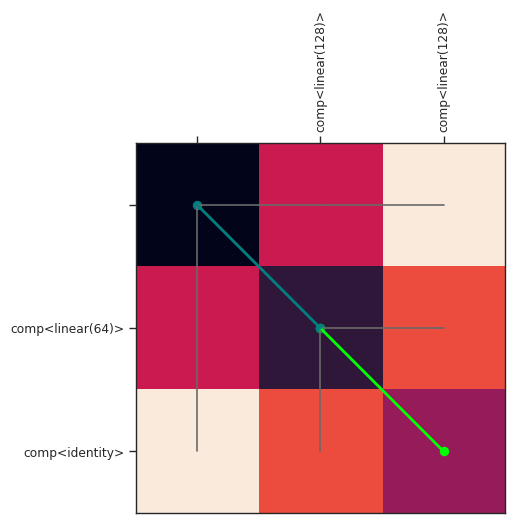

In [15]:
matrix = align_matrix(model1, model2, verbose = True)

In [16]:
matrix.verbose = True
offspring = []
for i in range(0, len(matrix.operations)):
    root = matrix.generate_offspring(matrix.operations[:i + 1])
    offspring.append(root)
print(matrix.operations)
print("Parents:")
print(f"{matrix.model1}")
print(f"{matrix.model2}")
print("Offspring:")
for child in offspring:
    print(f"{child}")

>>>Parent model 1
 sequential(computation<linear(128)>, computation<linear(128)>) 
>>>Parent model 2
 sequential(computation<linear(64)>, computation<identity>) 

>>>Mutating computation<linear(128)> into computation<identity>
 sequential(computation<linear(128)>, computation<linear(128)>) 

>>>Final model
 sequential(computation<linear(128)>, computation<linear(128)>)
>>>Parent model 1
 sequential(computation<linear(128)>, computation<linear(128)>) 
>>>Parent model 2
 sequential(computation<linear(64)>, computation<identity>) 

>>>Mutating computation<linear(128)> into computation<identity>
 sequential(computation<linear(128)>, computation<linear(128)>) 

>>>Mutating computation<linear(128)> into computation<linear(64)>
 sequential(computation<linear(128)>, computation<linear(128)>) 

>>>Final model
 sequential(computation<linear(128)>, computation<linear(128)>)
[['mut', (3, 3), (1, 1), (2, 2), 0.5], ['mut', (2, 2), (0, 0), (1, 1), 0.25]]
Parents:
sequential(computation<linear(64)>, c

In [6]:
matrix.generate_offspring()

>>>Parent model 1
 branching(4){group(4,2), computation<linear(512)>, cat(4,3)} 
>>>Parent model 2
 sequential(computation<linear(2048)>, computation<pos_enc>) 

>>>Adding computation<pos_enc> after branching(4){group(4,2), computation<linear(512)>, cat(4,3)}
 sequential(branching(4){group(4,2), computation<linear(512)>, cat(4,3)}, computation<pos_enc>) 

>>>Mutating branching(4){group(4,2), computation<linear(512)>, cat(4,3)} into computation<linear(2048)>
 sequential(computation<linear(2048)>, computation<pos_enc>) 

>>>Final model
 sequential(computation<linear(2048)>, computation<pos_enc>)


DerivationTreeNode(id=6, level=network, operation=Operation(sequential, nonterminal, ['module', 'module']), input_params={'shape': torch.Size([1, 3, 28, 28]), 'other_shape': None, 'mode': 'im', 'other_mode': None, 'branching_factor': 1, 'last_im_shape': None}, output_params={}, depth=0, address=0x76163694fb50)

In [ ]:
matrix = align_matrix(model1, model2, verbose = True)

In [ ]:
matrix.generate_offspring()

In [ ]:
matrix.operations.reverse()
matrix.generate_offspring()

In [ ]:
matrix.generate_offspring([matrix.operations[i] for i in [1,2]])

In [ ]:
matrix = align_matrix(model1, model2, verbose = True)
matrix.generate_offspring()

In [ ]:
matrix = align_matrix(model1, model2, verbose = True)
matrix.generate_offspring()